Автор:<br>Коваленко А.О.
<br>Студент 2 курса магистратуры кафедры "ИУ3" МГТУ им. Н.Э. Баумана<br>

Основанно на [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection)
#### Ячейка под импорты модулей

In [21]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from glob import glob

%matplotlib inline
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # большие изображения
plt.rcParams['image.interpolation'] = 'nearest'  # не использовать интерполяцию
plt.rcParams['image.cmap'] = 'gray'  # полутоновый режим вывода

sys.path.append("..")

from camo_test_functions import generate_camo_in_boxes,create_camo_images,average,plot_camo

#### Иморт модулей Object Detection API

In [22]:
from utils import label_map_util
from utils import visualization_utils as vis_util

#### Вспомогательный код

In [25]:
'''
Выгрузка графа модели в память.
'''
def load_detection_graph(path_to_graph):
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(path_to_graph, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

'''
Преобразование изображения в формат массива Numpy.
'''
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

'''
Распознавание.
'''
def detect_person_with_graph(detection_graph,image_paths_list):
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            # Объявление входных и выходных тензоров
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            all_scores = list()
            for image_path in image_paths_list:
                image = Image.open(image_path)
                image_np = load_image_into_numpy_array(image)
                # Размерность входного изображения должна быть: [1, None, None, 3]
                image_np_expanded = np.expand_dims(image_np, axis=0)
                # Распознавание.
                (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
                # Фильтруем детекции только для людей.
                l = list(zip(np.squeeze(boxes),np.squeeze(classes).astype(np.int32),np.squeeze(scores)))
                t = [t for t in l if t[1] == 1]
                b, c, s = list(zip(*t))
                np.array(b), np.array(c), np.array(s)
                all_scores += s
                # Визуализируем
                '''vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np,
                    np.array(b),
                    np.array(c).astype(np.int32),
                    np.array(s),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=2)
                plt.figure(figsize=(12, 8))
                plt.imshow(image_np)'''
            
            all_scores = list(filter(lambda x: x > 0.5, all_scores))
            n_det = len(all_scores)
            if n_det != 0: av_score = average(all_scores)
            else: av_score = 0
            print('Num detections: ' + str(n_det) + '/12')
            print('Average score: ' + str(av_score))
            return (n_det,av_score)

#### Выгрузка карты лейблов

In [26]:
PATH_TO_TEST_IMAGES_DIR = 'test_images'
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 1

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [27]:
camo_prob = list()

## 1 Тестируемая модель

Ниже представлен эксперимент с распознаванием различных камуфляжей моделью представленной в [Tensorflow Object Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), обученной на датасете [COCO](http://cocodataset.org/#home)


#### Faster-RCNN ResNet101
>* **Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks.** *Shaoqing Ren, Kaiming He, Ross Girshick, Jian Sun.* [Arxiv 2016](https://arxiv.org/abs/1506.01497)
>* **Deep Residual Learning for Image Recognition.** *Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.* [Arxiv 2015](https://arxiv.org/abs/1512.03385)


In [28]:
# Имя модели
MODEL_NAME = 'faster_rcnn_resnet101_coco_2017_11_08'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
# Загрузка графа модели
detection_graph = load_detection_graph(PATH_TO_CKPT)
# Всего людей на всех изображениях
PERSON_CNT = 12

### Оригинальные изображения

In [29]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/original/{}.jpg'.format(i)) for i in range(1, 4)])


Num detections: 12/12
Average score: 0.997534354528


### ACUPAT

In [30]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/acupat/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"acupat"))

Num detections: 8/12
Average score: 0.846340358257


### ATACS

In [31]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/atacs/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"atacs"))

Num detections: 3/12
Average score: 0.896888891856


### CADPAT

In [32]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/cadpat/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"cadpat"))

Num detections: 5/12
Average score: 0.868598079681


### Flecktarn (Дания)

In [33]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/Flecktarn_Danish/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"Flecktarn_Danish"))

Num detections: 3/12
Average score: 0.817372639974


### Flecktarn (Германия)

In [34]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/Flecktarn_Ger/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"Flecktarn_Ger"))

Num detections: 4/12
Average score: 0.815142393112


### Флора

In [35]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/flora/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"flora"))

Num detections: 2/12
Average score: 0.969311714172


### KSK Snow

In [36]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/ksk_snow_camo/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"ksk_snow_camo"))

Num detections: 6/12
Average score: 0.696306546529


 ### M05 Woodland (Финляндия)

In [37]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/M05_woodland_pattern_Fin/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"M05_woodland_pattern_Fin"))

Num detections: 5/12
Average score: 0.806433773041


### MARPAT

In [38]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/marpat_usa/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"marpat_usa"))

Num detections: 6/12
Average score: 0.965189933777


### Multicam

In [39]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/multicam/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"multicam"))

Num detections: 1/12
Average score: 0.99797219038


### Партизан

In [40]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/partizan_rus/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"partizan_rus"))

Num detections: 5/12
Average score: 0.937863349915


### Подлесок

In [41]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/podlesok/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"podlesok"))

Num detections: 2/12
Average score: 0.774116754532


### Растр

In [42]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/rastr/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"rastr"))

Num detections: 0/12
Average score: 0


### СКВО Спектр горный

In [43]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/Skwospectre_mount_Rus/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"Skwospectre_mount_Rus"))

Num detections: 6/12
Average score: 0.894951264064


### СКВО Спектр

In [44]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/Skwospectre_Rus/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"Skwospectre_Rus"))

Num detections: 3/12
Average score: 0.803219477336


### Смог

In [45]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/smog_rus/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"smog_rus"))

Num detections: 8/12
Average score: 0.839155435562


### Спектр

In [46]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/Spectre_Rus/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"Spectre_Rus"))

Num detections: 4/12
Average score: 0.950340390205


### Тигр камыш

In [47]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/tigr_kamysh/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"tigr_kamysh"))

Num detections: 9/12
Average score: 0.883166948954


### Town (США)

In [48]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/town_usa/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"town_usa"))

Num detections: 4/12
Average score: 0.756222486496


### Woodland

In [49]:
(ndet,av_score) = detect_person_with_graph(detection_graph,
                         [os.path.join(PATH_TO_TEST_IMAGES_DIR, 'camo/woodland/{}.jpg'.format(i)) for i in range(1, 4)])
camo_prob.append((ndet/PERSON_CNT,"woodland"))

Num detections: 4/12
Average score: 0.752316057682


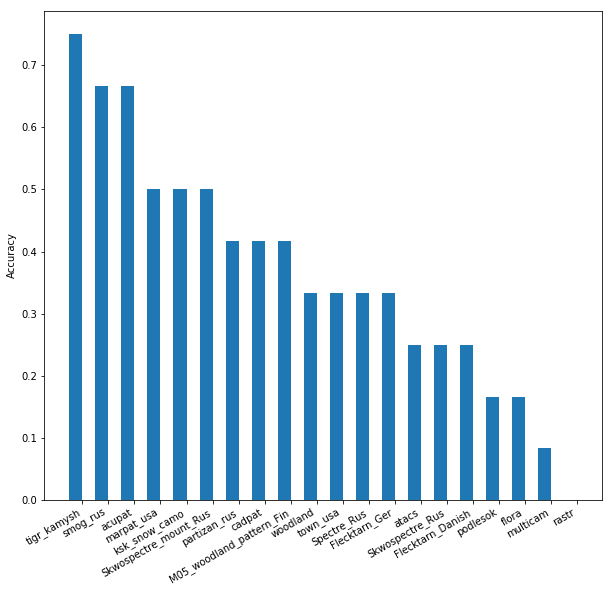

In [50]:


camo_prob.sort(reverse=True)

ys , labels = zip(*camo_prob)
xs = np.arange(len(labels))
width = 0.5

fig = plt.figure()
plt.ylabel('Accuracy')
ax = fig.gca()
ax.bar(xs, ys, width, align='center')

ax.set_xticks(xs + width / 2)
ax.set_xticklabels(labels)
fig.autofmt_xdate()


### Хорошо распознает:

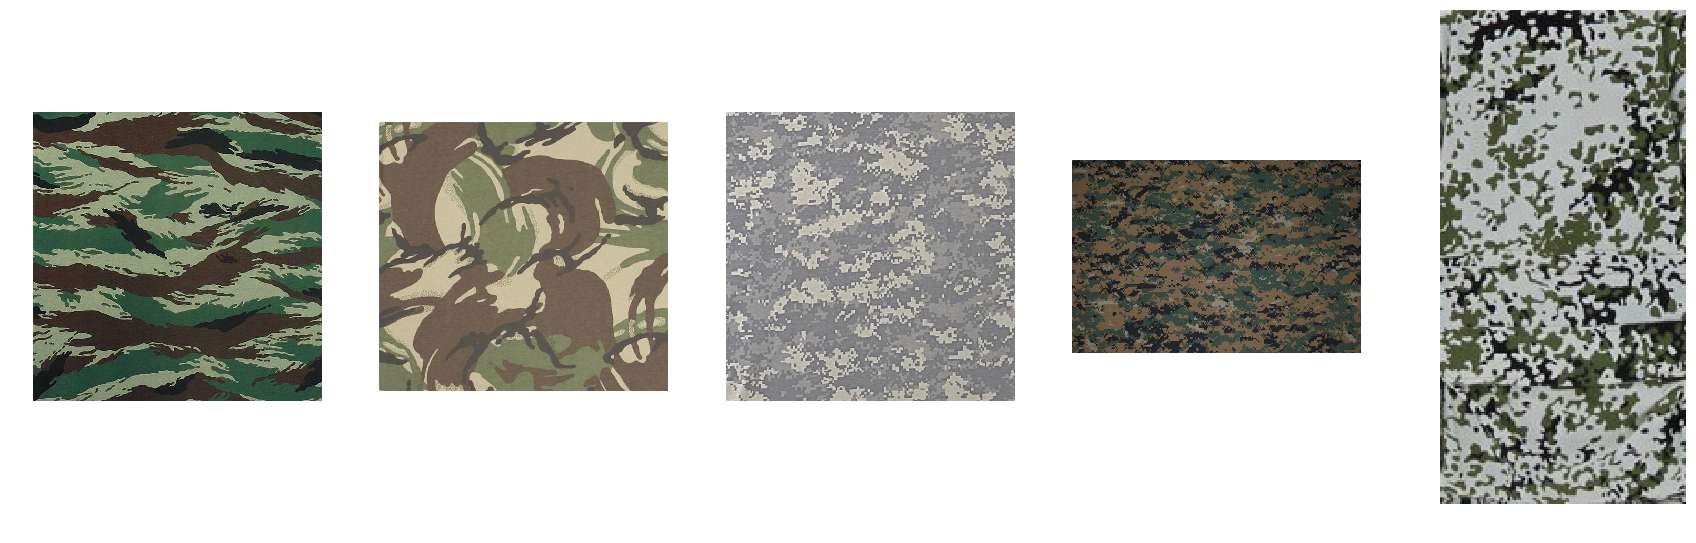

In [52]:
camo_prob.sort(reverse=True)
ys, labels = zip(*camo_prob)
plot_camo(labels,5)

### Плохо распознает:

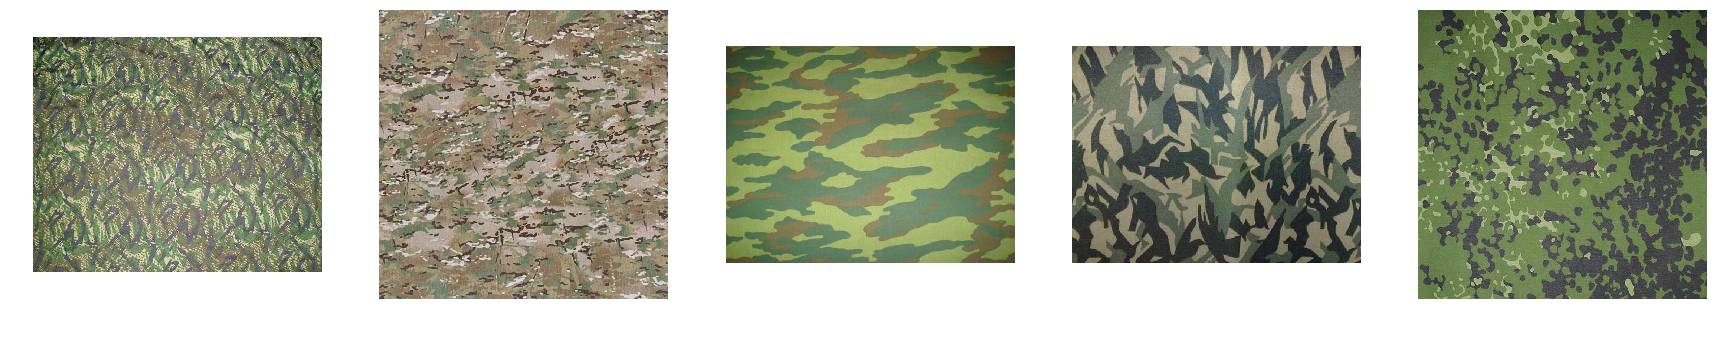

In [53]:
camo_prob.sort(reverse=False)
ys, labels = zip(*camo_prob)
plot_camo(labels,5)